In [12]:
import os
import pandas as pd
import librosa
import numpy as np
import random
import soundfile as sf
from tqdm import tqdm
import logging

# Set random seed for reproducibility (as in provided code)
random.seed(42)
np.random.seed(42)

# Setup logging
logging.basicConfig(filename='augmentation_log.txt', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
CONFIG = {
    'sample_rate': 44100,  # ESC-50 standard
    'augmentations_per_file': 5,  # To get 12,000 files (2,000 × (5 + 1))
    'output_dir': 'augmented_audio',
    'noise_factor': 0.005,
    'time_stretch_rate': 1.2,
    'pitch_shift_steps': 2,
    'max_time_shift': 1000,
    'volume_gain_db_range': (-10, 10)
}

# Load dataset metadata
metadata_path = "meta/esc50.csv"
try:
    data = pd.read_csv(metadata_path)
except Exception as e:
    logging.error(f"Failed to load metadata: {e}")
    raise

# Audio directory path
audio_dir = "audio"

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# Function to perform time stretching
def time_stretch(y, rate=CONFIG['time_stretch_rate']):
    try:
        return librosa.effects.time_stretch(y, rate=rate)
    except Exception as e:
        logging.warning(f"Time stretch failed: {e}")
        return y

# Function to perform pitch shifting
def pitch_shift(y, sr, n_steps=CONFIG['pitch_shift_steps']):
    try:
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    except Exception as e:
        logging.warning(f"Pitch shift failed: {e}")
        return y

# Function to add noise to the audio
def add_noise(y, noise_factor=CONFIG['noise_factor']):
    try:
        noise = np.random.randn(len(y))
        return y + noise_factor * noise
    except Exception as e:
        logging.warning(f"Add noise failed: {e}")
        return y

# Function to shift the audio in time
def time_shift(y, max_shift=CONFIG['max_time_shift']):
    try:
        shift = random.randint(-max_shift, max_shift)
        return np.roll(y, shift)
    except Exception as e:
        logging.warning(f"Time shift failed: {e}")
        return y

# Function to change the volume of the audio
def change_volume(y, gain_db):
    try:
        return y * (10 ** (gain_db / 20))
    except Exception as e:
        logging.warning(f"Volume change failed: {e}")
        return y

# Function to save augmented audio file
def save_augmented_audio(y, original_file_path, augmented_index, category, sr=CONFIG['sample_rate']):
    try:
        base_name = os.path.basename(original_file_path)
        name, ext = os.path.splitext(base_name)
        augmented_filename = f"{name}_augmented_{augmented_index}{ext}"
        augmented_file_path = os.path.join(CONFIG['output_dir'], augmented_filename)
        sf.write(augmented_file_path, y, sr)
        return augmented_file_path, augmented_filename
    except Exception as e:
        logging.error(f"Failed to save {augmented_file_path}: {e}")
        return None, None

# Function to augment audio
def augment_audio(y, sr, original_file_path, category, augmentations=CONFIG['augmentations_per_file']):
    augmented_files = []
    metadata_entries = []
    
    # Save original file
    original_path, original_filename = save_augmented_audio(y, original_file_path, 'original', category, sr)
    if original_path:
        augmented_files.append(original_path)
        metadata_entries.append({
            'filename': original_filename,
            'category': category,
            'augmentation_type': 'original',
            'original_file': os.path.basename(original_file_path)
        })
    
    # Apply augmentations
    for i in range(augmentations):
        augmented_y = y.copy()
        augmentation_type = random.choice(['time_stretch', 'pitch_shift', 'add_noise', 'time_shift', 'volume'])
        gain_db = None

        try:
            if augmentation_type == 'time_stretch':
                augmented_y = time_stretch(augmented_y)
            elif augmentation_type == 'pitch_shift':
                augmented_y = pitch_shift(augmented_y, sr)
            elif augmentation_type == 'add_noise':
                augmented_y = add_noise(augmented_y)
            elif augmentation_type == 'time_shift':
                augmented_y = time_shift(augmented_y)
            elif augmentation_type == 'volume':
                gain_db = random.uniform(*CONFIG['volume_gain_db_range'])
                augmented_y = change_volume(augmented_y, gain_db)
            
            # Save augmented file
            augmented_path, augmented_filename = save_augmented_audio(augmented_y, original_file_path, i, category, sr)
            if augmented_path:
                augmented_files.append(augmented_path)
                metadata_entries.append({
                    'filename': augmented_filename,
                    'category': category,
                    'augmentation_type': augmentation_type if augmentation_type != 'volume' else f'volume_{gain_db:.2f}dB',
                    'original_file': os.path.basename(original_file_path)
                })
        
        except Exception as e:
            logging.error(f"Error during augmentation {i} ({augmentation_type}) for {original_file_path}: {e}")

    return augmented_files, metadata_entries

# Augment audio files and collect metadata
augmented_files_list = []
augmented_metadata = []

for index, row in tqdm(data.iterrows(), total=len(data), desc="Augmenting audio files"):
    file_name = row['filename']
    category = row['category']
    file_path = os.path.join(audio_dir, file_name)
    
    try:
        y, sr = librosa.load(file_path, sr=CONFIG['sample_rate'])
        augmented_files, metadata_entries = augment_audio(y, sr, file_path, category)
        augmented_files_list.extend(augmented_files)
        augmented_metadata.extend(metadata_entries)
        logging.info(f"Augmented {file_name}: {len(augmented_files)} files created")
    except Exception as e:
        logging.error(f"Error processing {file_name}: {e}")

# Save augmented metadata to CSV
augmented_metadata_df = pd.DataFrame(augmented_metadata)
augmented_metadata_df.to_csv('augmented_esc50.csv', index=False)
logging.info("Saved augmented metadata to augmented_esc50.csv")

print(f"Generated {len(augmented_files_list)} augmented audio files.")
print("Augmented metadata saved to augmented_esc50.csv")

Augmenting audio files: 100%|██████████████████████████████████████████████████| 2000/2000 [08:43<00:00,  3.82it/s]

Generated 12000 augmented audio files.
Augmented metadata saved to augmented_esc50.csv


In [13]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import logging

# Setup logging
logging.basicConfig(filename='eda_log.txt', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
CONFIG = {
    'augmented_dir': 'augmented_audio',
    'metadata_path': 'augmented_esc50.csv',
    'sample_rate': 44100,
    'plot_dir': 'eda_plots'
}

# Create plot directory
os.makedirs(CONFIG['plot_dir'], exist_ok=True)

# Load augmented metadata
try:
    metadata = pd.read_csv(CONFIG['metadata_path'])
    logging.info(f"Loaded metadata with {len(metadata)} entries")
except Exception as e:
    logging.error(f"Failed to load metadata: {e}")
    raise

# Basic metadata statistics
print("Metadata Summary:")
print(f"Total files: {len(metadata)}")
print(f"Unique categories: {metadata['category'].nunique()}")
print(f"Unique augmentation types: {metadata['augmentation_type'].nunique()}")

# Category distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='category', order=metadata['category'].value_counts().index)
plt.title('Distribution of Categories in Augmented Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Files')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['plot_dir'], 'category_distribution.png'))
plt.close()
logging.info("Saved category distribution plot")

# Augmentation type distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata, x='augmentation_type', order=metadata['augmentation_type'].value_counts().index)
plt.title('Distribution of Augmentation Types')
plt.xlabel('Augmentation Type')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['plot_dir'], 'augmentation_type_distribution.png'))
plt.close()
logging.info("Saved augmentation type distribution plot")

# Analyze audio file properties (duration and sample rate)
durations = []
sample_rates = []

# Sample a subset of files to avoid long processing (e.g., 10% of files)
sample_files = metadata['filename'].sample(frac=0.1, random_state=42)

for filename in tqdm(sample_files, desc="Analyzing audio files"):
    file_path = os.path.join(CONFIG['augmented_dir'], filename)
    try:
        y, sr = librosa.load(file_path, sr=None)
        durations.append(librosa.get_duration(y=y, sr=sr))
        sample_rates.append(sr)
    except Exception as e:
        logging.warning(f"Error processing {filename}: {e}")

# Duration statistics
durations = np.array(durations)
print("\nDuration Statistics (seconds):")
print(f"Mean: {durations.mean():.2f}")
print(f"Std: {durations.std():.2f}")
print(f"Min: {durations.min():.2f}")
print(f"Max: {durations.max():.2f}")

# Sample rate statistics
sample_rates = np.array(sample_rates)
print("\nSample Rate Statistics (Hz):")
print(f"Unique sample rates: {np.unique(sample_rates)}")

# Plot duration distribution
plt.figure(figsize=(10, 5))
sns.histplot(durations, bins=30, kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['plot_dir'], 'duration_distribution.png'))
plt.close()
logging.info("Saved duration distribution plot")

# Visualize spectrograms for a sample file (original vs. augmented)
sample_category = metadata['category'].iloc[0]  # Pick first category
sample_original = metadata[metadata['augmentation_type'] == 'original'].iloc[0]
sample_augmented = metadata[(metadata['original_file'] == sample_original['original_file']) & 
                           (metadata['augmentation_type'].str.contains('time_stretch'))].iloc[0]

def plot_spectrogram(y, sr, title, filename):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['plot_dir'], filename))
    plt.close()

# Load and plot spectrograms
try:
    y_orig, sr_orig = librosa.load(os.path.join(CONFIG['augmented_dir'], sample_original['filename']), sr=CONFIG['sample_rate'])
    y_aug, sr_aug = librosa.load(os.path.join(CONFIG['augmented_dir'], sample_augmented['filename']), sr=CONFIG['sample_rate'])
    
    plot_spectrogram(y_orig, sr_orig, f"Original Spectrogram ({sample_original['category']})", 'spectrogram_original.png')
    plot_spectrogram(y_aug, sr_aug, f"Time-Stretched Spectrogram ({sample_augmented['category']})", 'spectrogram_time_stretch.png')
    logging.info("Saved spectrogram plots")
except Exception as e:
    logging.error(f"Error generating spectrograms: {e}")

# Save summary to file
with open(os.path.join(CONFIG['plot_dir'], 'eda_summary.txt'), 'w') as f:
    f.write("Augmented ESC-50 Dataset EDA Summary\n")
    f.write(f"Total files: {len(metadata)}\n")
    f.write(f"Unique categories: {metadata['category'].nunique()}\n")
    f.write(f"Unique augmentation types: {metadata['augmentation_type'].nunique()}\n")
    f.write("\nDuration Statistics (seconds):\n")
    f.write(f"Mean: {durations.mean():.2f}\n")
    f.write(f"Std: {durations.std():.2f}\n")
    f.write(f"Min: {durations.min():.2f}\n")
    f.write(f"Max: {durations.max():.2f}\n")
    f.write("\nSample Rate Statistics (Hz):\n")
    f.write(f"Unique sample rates: {np.unique(sample_rates)}\n")
logging.info("Saved EDA summary")

print("EDA completed. Plots saved in 'eda_plots/' and summary in 'eda_summary.txt'")

Metadata Summary:
Total files: 12000
Unique categories: 50
Unique augmentation types: 1269


Analyzing audio files: 100%|██████████████████████████████████████████████████| 1200/1200 [00:01<00:00, 726.25it/s]



Duration Statistics (seconds):
Mean: 4.85
Std: 0.32
Min: 4.17
Max: 5.00

Sample Rate Statistics (Hz):
Unique sample rates: [44100]
EDA completed. Plots saved in 'eda_plots/' and summary in 'eda_summary.txt'


In [14]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# Configuration
CONFIG = {
    'augmented_dir': 'augmented_audio',  # Directory with augmented audio files
    'metadata_path': 'augmented_esc50.csv',  # Path to metadata CSV
    'sample_rate': 44100,  # Standard sample rate for ESC-50
    'plot_dir': 'eda_plots'  # Directory to save plots
}

# Create plot directory if it doesn’t exist
os.makedirs(CONFIG['plot_dir'], exist_ok=True)

# Load metadata
metadata = pd.read_csv(CONFIG['metadata_path'])
print(f"Loaded metadata with {len(metadata)} entries")

# 1. Bar Plot: Category Distribution
plt.figure(figsize=(12, 6))
category_counts = metadata['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of Categories in Augmented Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Files')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['plot_dir'], 'category_distribution.png'))
plt.close()
print("Saved category distribution plot")

# 2. Bar Plot: Augmentation Type Distribution
plt.figure(figsize=(10, 5))
augmentation_counts = metadata['augmentation_type'].value_counts()
sns.barplot(x=augmentation_counts.index, y=augmentation_counts.values)
plt.title('Distribution of Augmentation Types')
plt.xlabel('Augmentation Type')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['plot_dir'], 'augmentation_type_distribution.png'))
plt.close()
print("Saved augmentation type distribution plot")

# 3. Histogram: Audio Durations (using a 10% sample for efficiency)
durations = []
sample_files = metadata['filename'].sample(frac=0.1, random_state=42)  # Sample 10% of files
for filename in tqdm(sample_files, desc="Analyzing audio durations"):
    file_path = os.path.join(CONFIG['augmented_dir'], filename)
    y, sr = librosa.load(file_path, sr=None)
    durations.append(librosa.get_duration(y=y, sr=sr))

plt.figure(figsize=(10, 5))
sns.histplot(durations, bins=30, kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['plot_dir'], 'duration_distribution.png'))
plt.close()
print("Saved duration distribution plot")

# 4. Spectrogram Plots: Original vs Augmented
sample_category = metadata['category'].iloc[0]
sample_original = metadata[metadata['augmentation_type'] == 'original'].iloc[0]
sample_augmented = metadata[(metadata['original_file'] == sample_original['original_file']) & 
                            (metadata['augmentation_type'] != 'original')].iloc[0]

def plot_spectrogram(y, sr, title, filename):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['plot_dir'], filename))
    plt.close()

# Load and plot spectrograms
y_orig, sr_orig = librosa.load(os.path.join(CONFIG['augmented_dir'], sample_original['filename']), sr=CONFIG['sample_rate'])
y_aug, sr_aug = librosa.load(os.path.join(CONFIG['augmented_dir'], sample_augmented['filename']), sr=CONFIG['sample_rate'])

plot_spectrogram(y_orig, sr_orig, f"Original Spectrogram ({sample_original['category']})", 'spectrogram_original.png')
plot_spectrogram(y_aug, sr_aug, f"Augmented Spectrogram ({sample_augmented['augmentation_type']})", 'spectrogram_augmented.png')
print("Saved spectrogram plots")

print("All EDA diagrams saved in 'eda_plots/'")

Loaded metadata with 12000 entries
Saved category distribution plot
Saved augmentation type distribution plot


Analyzing audio durations: 100%|█████████████████████████████████████████████| 1200/1200 [00:01<00:00, 1042.89it/s]


Saved duration distribution plot
Saved spectrogram plots
All EDA diagrams saved in 'eda_plots/'


In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(filename='knn_log.txt', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
CONFIG = {
    'augmented_dir': 'augmented_audio',  # Directory with augmented audio files
    'metadata_path': 'augmented_esc50.csv',  # Path to metadata CSV
    'sample_rate': 44100,  # Standard sample rate for ESC-50
    'n_mels': 128,  # Number of Mel frequency bins
    'hop_length': 512,  # Hop length for Mel spectrogram
    'n_fft': 2048,  # FFT window size
    'target_frames': 427,  # Target number of time frames for 5-second audio
    'pca_components': 100,  # Number of PCA components
    'test_size': 0.2,  # Test set size
    'random_state': 42  # Random seed for reproducibility
}

# Load metadata
try:
    metadata = pd.read_csv(CONFIG['metadata_path'])
    logging.info(f"Loaded metadata with {len(metadata)} entries")
except Exception as e:
    logging.error(f"Failed to load metadata: {e}")
    raise

# Function to extract Mel spectrogram features with padding/truncating
def extract_features(file_path):
    try:
        # Load audio without duration limit
        y, sr = librosa.load(file_path, sr=CONFIG['sample_rate'])
        # Compute Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_mels=CONFIG['n_mels'],
            hop_length=CONFIG['hop_length'],
            n_fft=CONFIG['n_fft']
        )
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        # Pad or truncate to fixed number of frames
        if log_mel_spec.shape[1] < CONFIG['target_frames']:
            pad_width = CONFIG['target_frames'] - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
        elif log_mel_spec.shape[1] > CONFIG['target_frames']:
            log_mel_spec = log_mel_spec[:, :CONFIG['target_frames']]
        # Flatten to 1D array
        return log_mel_spec.flatten()
    except Exception as e:
        logging.warning(f"Error processing {file_path}: {e}")
        return None

# Prepare dataset
features = []
labels = []

for index, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting features"):
    file_path = os.path.join(CONFIG['augmented_dir'], row['filename'])
    label = row['category']
    feat = extract_features(file_path)
    if feat is not None:
        features.append(feat)
        labels.append(label)

# Convert to arrays
X = np.array(features)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=CONFIG['test_size'], random_state=CONFIG['random_state'])

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality reduction with PCA
pca = PCA(n_components=CONFIG['pca_components'])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
logging.info(f"PCA reduced features to {CONFIG['pca_components']} components")

# KNN Model with Cross-Validation and Hyperparameter Tuning
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)
best_knn = grid_search.best_estimator_
logging.info(f"Best KNN parameters: {grid_search.best_params_}")

# Cross-validation scores
cv_scores = cross_val_score(best_knn, X_train_pca, y_train, cv=5, scoring='f1_macro')
logging.info(f"Cross-validation F1 scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Evaluate on test set
y_pred = best_knn.predict(X_test_pca)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nKNN Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()
logging.info("Saved confusion matrix plot")

# Feature Importance (Permutation Importance)
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_knn, X_test_pca, y_test, n_repeats=10, random_state=CONFIG['random_state'])
sorted_idx = perm_importance.importances_mean.argsort()[-10:]  # Top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(10), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(10), [f'PC{i+1}' for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Important Features (PCA Components)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()
logging.info("Saved feature importance plot")

# Save results to file
with open('knn_results.txt', 'w') as f:
    f.write("KNN Model Results on Augmented ESC-50\n")
    f.write(f"Best Parameters: {grid_search.best_params_}\n")
    f.write(f"Cross-Validation F1 Score (macro): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"F1 Score (macro): {f1:.4f}\n")
    f.write(f"Precision (macro): {precision:.4f}\n")
    f.write(f"Recall (macro): {recall:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=le.classes_))
logging.info("Saved KNN results to knn_results.txt")

print("KNN model training and evaluation completed. Results saved in 'knn_results.txt' and plots in 'confusion_matrix.png' and 'feature_importance.png'")

Extracting features: 100%|███████████████████████████████████████████████████| 12000/12000 [03:10<00:00, 62.89it/s]



KNN Model Performance:
Accuracy: 0.8071
F1 Score (macro): 0.8082
Precision (macro): 0.8240
Recall (macro): 0.8101

Classification Report:
                   precision    recall  f1-score   support

        airplane       0.71      0.74      0.73        54
       breathing       0.81      0.70      0.75        56
  brushing_teeth       0.75      0.78      0.77        46
     can_opening       0.89      0.71      0.79        48
        car_horn       0.65      0.72      0.68        43
             cat       0.62      0.89      0.73        46
        chainsaw       0.89      0.82      0.85        50
  chirping_birds       0.69      0.86      0.77        44
    church_bells       0.86      0.77      0.81        57
        clapping       0.86      0.84      0.85        51
     clock_alarm       0.97      1.00      0.99        37
      clock_tick       0.83      0.83      0.83        46
        coughing       0.92      0.76      0.83        45
             cow       0.87      0.93      0.90

In [5]:
#applying KNN model with argumented data

In [6]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(filename='knn_log.txt', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration with memory-efficient settings
CONFIG = {
    'augmented_dir': 'augmented_audio',  # Directory with augmented audio files
    'metadata_path': 'augmented_esc50.csv',  # Path to metadata CSV
    'sample_rate': 44100,  # Standard sample rate for ESC-50
    'n_mels': 128,  # Number of Mel frequency bins
    'hop_length': 1024,  # Increased from 512 to reduce feature size
    'n_fft': 2048,  # FFT window size
    'target_frames': 214,  # For 5s audio with hop_length=1024
    'pca_components': 100,  # Number of PCA components
    'test_size': 0.2,  # Test set size
    'random_state': 42  # Random seed for reproducibility
}

# Load metadata
try:
    metadata = pd.read_csv(CONFIG['metadata_path'])
    logging.info(f"Loaded metadata with {len(metadata)} entries")
except Exception as e:
    logging.error(f"Failed to load metadata: {e}")
    raise


Extracting features: 100%|███████████████████████████████████████████████████| 12000/12000 [03:02<00:00, 65.60it/s]



KNN Model Performance:
Accuracy: 0.8125
F1 Score (macro): 0.8135
Precision (macro): 0.8274
Recall (macro): 0.8145

Classification Report:
                   precision    recall  f1-score   support

        airplane       0.74      0.78      0.76        54
       breathing       0.85      0.73      0.79        56
  brushing_teeth       0.72      0.74      0.73        46
     can_opening       0.89      0.71      0.79        48
        car_horn       0.65      0.70      0.67        43
             cat       0.59      0.87      0.70        46
        chainsaw       0.93      0.84      0.88        50
  chirping_birds       0.70      0.86      0.78        44
    church_bells       0.88      0.81      0.84        57
        clapping       0.85      0.88      0.87        51
     clock_alarm       0.97      1.00      0.99        37
      clock_tick       0.89      0.85      0.87        46
        coughing       0.94      0.73      0.82        45
             cow       0.87      0.93      0.90

In [ ]:

# Function to extract Mel spectrogram features with padding/truncating and float32
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=CONFIG['sample_rate'])
        mel_spec = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_mels=CONFIG['n_mels'],
            hop_length=CONFIG['hop_length'],
            n_fft=CONFIG['n_fft']
        )
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)
        if log_mel_spec.shape[1] < CONFIG['target_frames']:
            pad_width = CONFIG['target_frames'] - log_mel_spec.shape[1]
            log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')
        elif log_mel_spec.shape[1] > CONFIG['target_frames']:
            log_mel_spec = log_mel_spec[:, :CONFIG['target_frames']]
        return log_mel_spec.flatten()
    except Exception as e:
        logging.warning(f"Error processing {file_path}: {e}")
        return None



In [ ]:
# Prepare dataset
features = []
labels = []

for index, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting features"):
    file_path = os.path.join(CONFIG['augmented_dir'], row['filename'])
    label = row['category']
    feat = extract_features(file_path)
    if feat is not None:
        features.append(feat)
        labels.append(label)

# Convert to arrays
X = np.array(features)
y = np.array(labels)


In [ ]:

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=CONFIG['test_size'], random_state=CONFIG['random_state'])

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality reduction with IncrementalPCA
ipca = IncrementalPCA(n_components=CONFIG['pca_components'], batch_size=1000)
X_train_pca = ipca.fit_transform(X_train_scaled)
X_test_pca = ipca.transform(X_test_scaled)
logging.info(f"IncrementalPCA reduced features to {CONFIG['pca_components']} components")

# KNN Model with Cross-Validation and Hyperparameter Tuning (n_jobs=1)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro', n_jobs=1)
grid_search.fit(X_train_pca, y_train)
best_knn = grid_search.best_estimator_
logging.info(f"Best KNN parameters: {grid_search.best_params_}")


In [ ]:

# Cross-validation scores
cv_scores = cross_val_score(best_knn, X_train_pca, y_train, cv=5, scoring='f1_macro')
logging.info(f"Cross-validation F1 scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Evaluate on test set
y_pred = best_knn.predict(X_test_pca)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nKNN Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()
logging.info("Saved confusion matrix plot")


In [ ]:

# Feature Importance (Permutation Importance) on a subset
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_knn, X_test_pca[:1000], y_test[:1000], n_repeats=5, random_state=CONFIG['random_state'])
sorted_idx = perm_importance.importances_mean.argsort()[-10:]  # Top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(10), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(10), [f'PC{i+1}' for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Important Features (PCA Components)')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()
logging.info("Saved feature importance plot")


In [ ]:

# Save results to file
with open('knn_results.txt', 'w') as f:
    f.write("KNN Model Results on Augmented ESC-50\n")
    f.write(f"Best Parameters: {grid_search.best_params_}\n")
    f.write(f"Cross-Validation F1 Score (macro): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"F1 Score (macro): {f1:.4f}\n")
    f.write(f"Precision (macro): {precision:.4f}\n")
    f.write(f"Recall (macro): {recall:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=le.classes_))
logging.info("Saved KNN results to knn_results.txt")

print("KNN model training and evaluation completed. Results saved in 'knn_results.txt' and plots in 'confusion_matrix.png' and 'feature_importance.png'")

In [7]:
#applying svm model

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")






In [2]:

# ---------------------------
# 1. Load or Generate Metadata CSV
# ---------------------------
csv_file = "augmented_esc50.csv"

def generate_dummy_csv(audio_dir="augmented_audio", csv_out="augmented_esc50.csv"):
    data = []
    for file in os.listdir(audio_dir):
        if file.endswith('.wav'):
            category = file.split('_')[0]
            data.append({'filename': file, 
                         'category': category, 
                         'filepath': os.path.join(audio_dir, file)})
    if data:
        df_dummy = pd.DataFrame(data)
        df_dummy.to_csv(csv_out, index=False)
        print("Dummy CSV generated with {} entries.".format(len(data)))
        return df_dummy
    else:
        sys.exit("No audio files found in the directory: '{}'".format(audio_dir))

if not os.path.exists(csv_file):
    print(f"CSV file '{csv_file}' not found. Generating dummy CSV...")
    df = generate_dummy_csv()
else:
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"CSV file '{csv_file}' is empty. Generating dummy CSV...")
        df = generate_dummy_csv()

if 'filepath' not in df.columns:
    print("No 'filepath' column found; generating file paths using 'filename' and 'augmented_audio' directory.")
    df['filepath'] = df['filename'].apply(lambda x: os.path.join('augmented_audio', x))

try:
    sample_path = df['filepath'].iloc[0]
except IndexError:
    sys.exit("Error: The CSV file does not contain any entries.")

if not os.path.exists(sample_path):
    print(f"Warning: Sample file '{sample_path}' does not exist. Please verify the location of your augmented audio files.")


No 'filepath' column found; generating file paths using 'filename' and 'augmented_audio' directory.


In [3]:
# ---------------------------
# 2. Feature Extraction Function for SVM
# ---------------------------
def extract_features_svm(file_path):
    """
    Loads an audio file, extracts MFCC features, and computes summary statistics.
    Returns:
        np.ndarray: 1D array of features (mean, std, min, max for each MFCC coefficient)
    """
    try:
        y, sr = librosa.load(file_path, sr=44100)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_min = np.min(mfcc, axis=1)
        mfcc_max = np.max(mfcc, axis=1)
        features = np.concatenate((mfcc_mean, mfcc_std, mfcc_min, mfcc_max))
        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None



In [11]:
# ---------------------------
# 3. Process Files: Extract Features & Labels
# ---------------------------
features = []
labels = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    file_path = row['filepath']
    category = row['category']
    feat = extract_features_svm(file_path)
    if feat is not None:
        features.append(feat)
        labels.append(category)
    else:
        print(f"Skipping {file_path} due to extraction error.")

if len(features) == 0:
    sys.exit("Error: No features were extracted; please verify your file paths and audio files.")

X = np.array(features)
y = np.array(labels)



Extracting features: 100%|███████████████████████████████████████████████████| 12000/12000 [04:11<00:00, 47.81it/s]


In [12]:
# ---------------------------
# 4. Split Data into Training and Test Sets
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [13]:
# ---------------------------
# 5. Scale the Features
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [14]:
# ---------------------------
# 6. Train SVM Classifier
# ---------------------------
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)



SVC(random_state=42)

In [15]:
# ---------------------------
# 7. Predict Classes for the Test Set
# ---------------------------
y_pred = svm_model.predict(X_test_scaled)



In [16]:
# ---------------------------
# 8. Evaluate the SVM Model
# ---------------------------
print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred))


✅ Classification Report:

                  precision    recall  f1-score   support

        airplane       0.88      0.77      0.82        48
       breathing       0.94      0.92      0.93        48
  brushing_teeth       0.98      0.96      0.97        48
     can_opening       0.96      1.00      0.98        48
        car_horn       0.92      0.75      0.83        48
             cat       0.92      0.96      0.94        48
        chainsaw       0.78      0.83      0.81        48
  chirping_birds       0.96      0.98      0.97        48
    church_bells       0.74      0.83      0.78        48
        clapping       0.96      0.98      0.97        48
     clock_alarm       0.94      0.96      0.95        48
      clock_tick       0.88      0.73      0.80        48
        coughing       1.00      1.00      1.00        48
             cow       0.93      0.85      0.89        48
  crackling_fire       0.92      0.96      0.94        48
        crickets       0.90      0.96      0.

In [17]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (weighted): {precision:.2f}")
print(f"Recall (weighted): {recall:.2f}")
print(f"F1 Score (weighted): {f1:.2f}")

# ---------------------------


Accuracy: 0.90
Precision (weighted): 0.90
Recall (weighted): 0.90
F1 Score (weighted): 0.90


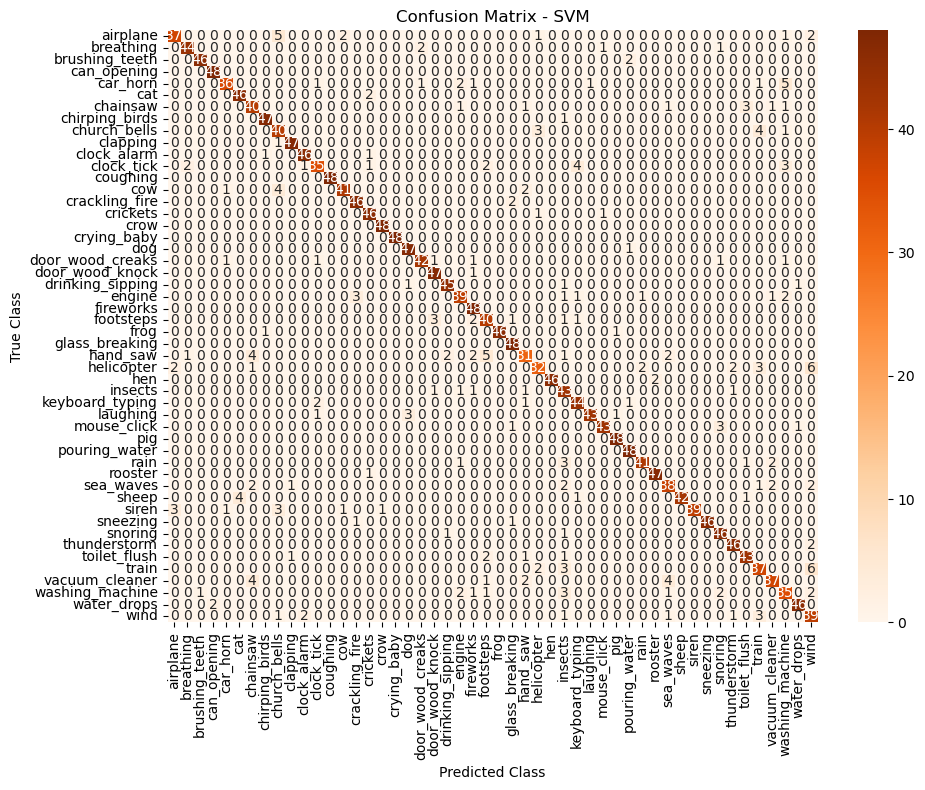

In [13]:
# 9. Plot and Display the Confusion Matrix
# ---------------------------
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()

In [ ]:
#applying hmm

No 'filepath' column found; generating file paths using 'filename' and 'augmented_audio' directory.


Predicting: 100%|██████████████████████████████████████████████████████████████| 2400/2400 [00:47<00:00, 50.77it/s]


✅ Classification Report:

                  precision    recall  f1-score   support

        airplane       0.49      0.50      0.49        48
       breathing       0.35      0.23      0.28        48
  brushing_teeth       0.62      0.67      0.64        48
     can_opening       0.28      0.38      0.32        48
        car_horn       0.44      0.40      0.42        48
             cat       0.39      0.15      0.21        48
        chainsaw       0.55      0.54      0.55        48
  chirping_birds       0.67      0.65      0.66        48
    church_bells       0.47      0.38      0.42        48
        clapping       0.71      0.75      0.73        48
     clock_alarm       0.67      0.50      0.57        48
      clock_tick       0.16      0.42      0.23        48
        coughing       0.27      0.38      0.32        48
             cow       0.58      0.44      0.50        48
  crackling_fire       0.56      0.60      0.58        48
        crickets       0.86      0.50      0.

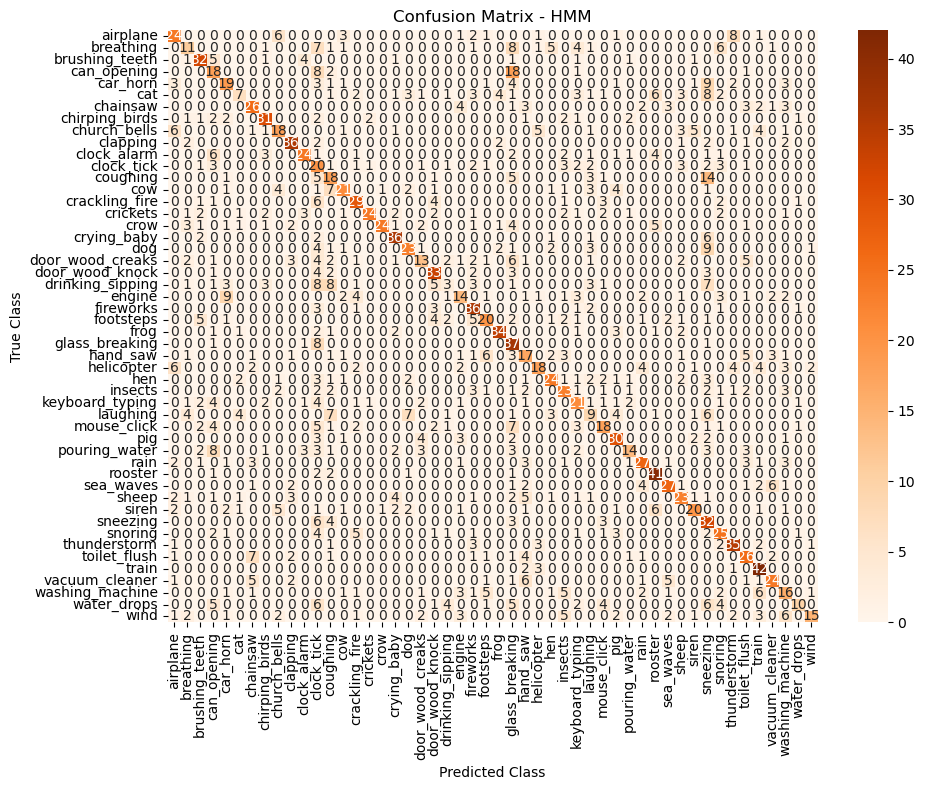

In [14]:
import os
import sys
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn import hmm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 1. Load or Generate Metadata CSV
# ---------------------------
csv_file = "augmented_esc50.csv"

# Function to generate a dummy CSV based on files found in the given directory.
def generate_dummy_csv(audio_dir="augmented_audio", csv_out="augmented_esc50.csv"):
    data = []
    for file in os.listdir(audio_dir):
        if file.endswith('.wav'):
            # Attempt to extract category using splitting: 
            # This example assumes filenames like "dog_aug0_time_stretch.wav"
            category = file.split('_')[0]
            data.append({'filename': file, 
                         'category': category, 
                         'filepath': os.path.join(audio_dir, file)})
    if data:
        df_dummy = pd.DataFrame(data)
        df_dummy.to_csv(csv_out, index=False)
        print("Dummy CSV generated with {} entries.".format(len(data)))
        return df_dummy
    else:
        sys.exit("No audio files found in the directory: '{}'".format(audio_dir))

# Check if the CSV file exists.
if not os.path.exists(csv_file):
    print(f"CSV file '{csv_file}' not found. Generating dummy CSV...")
    df = generate_dummy_csv()
else:
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"CSV file '{csv_file}' is empty. Generating dummy CSV...")
        df = generate_dummy_csv()

# Ensure the CSV has a 'filepath' column, otherwise generate it from 'filename'
if 'filepath' not in df.columns:
    print("No 'filepath' column found; generating file paths using 'filename' and 'augmented_audio' directory.")
    df['filepath'] = df['filename'].apply(lambda x: os.path.join('augmented_audio', x))

# Debug check: Verify that at least one sample exists and its file path is valid.
try:
    sample_path = df['filepath'].iloc[0]
except IndexError:
    sys.exit("Error: The CSV file does not contain any entries.")

if not os.path.exists(sample_path):
    print(f"Warning: Sample file '{sample_path}' does not exist. Please verify the location of your augmented audio files.")

# ---------------------------
# 2. Feature Extraction Function for HMM
# ---------------------------
def extract_features(file_path):
    """
    Loads an audio file and extracts MFCC features.
    Returns:
        np.ndarray: 2D array (time frames x MFCC coefficients)
    """
    try:
        y, sr = librosa.load(file_path, sr=44100)
        # Extract 13 MFCC coefficients and transpose so that rows represent time frames.
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return mfcc.T  
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# ---------------------------
# 3. Process Files: Extract Features & Labels
# ---------------------------
features = []
labels = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    file_path = row['filepath']
    category = row['category']
    mfcc_seq = extract_features(file_path)
    if mfcc_seq is not None:
        features.append(mfcc_seq)
        labels.append(category)
    else:
        print(f"Skipping {file_path} due to extraction error.")

if len(features) == 0:
    sys.exit("Error: No features were extracted; please verify your file paths and audio files.")

# ---------------------------
# 4. Split Data into Training and Test Sets
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, stratify=labels, test_size=0.2, random_state=42
)

# ---------------------------
# 5. Train HMM Classifiers (One per Class)
# ---------------------------
# Get sorted list of unique classes
classes = sorted(list(set(y_train)))
models = {}

for cls in tqdm(classes, desc="Training HMMs"):
    # Collect training sequences for this class
    X_cls = [seq for seq, label in zip(X_train, y_train) if label == cls]
    lengths = [len(seq) for seq in X_cls]
    # Concatenate all sequences for the class along the time axis.
    try:
        X_concat = np.concatenate(X_cls, axis=0)
    except Exception as e:
        print(f"Error concatenating sequences for class {cls}: {e}")
        continue
    # Create and train a Gaussian HMM (number of states can be tuned)
    model = hmm.GaussianHMM(n_components=4, covariance_type='diag', n_iter=1000, random_state=42)
    model.fit(X_concat, lengths)
    models[cls] = model

# ---------------------------
# 6. Function for Predicting a Class Given MFCC Sequence
# ---------------------------
def predict_class(mfcc_seq, models):
    """
    Given a MFCC sequence and a dictionary of trained HMMs, returns the class
    with the highest log-likelihood score.
    """
    scores = {}
    for cls, model in models.items():
        try:
            score = model.score(mfcc_seq)
        except Exception as e:
            score = float('-inf')
        scores[cls] = score
    return max(scores, key=scores.get)

# ---------------------------
# 7. Predict Classes for the Test Set
# ---------------------------
y_pred = []
for seq in tqdm(X_test, desc="Predicting"):
    y_pred.append(predict_class(seq, models))

# ---------------------------
# 8. Evaluate the HMM Model
# ---------------------------
print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ---------------------------
# 9. Plot and Display the Confusion Matrix
# ---------------------------
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - HMM")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


In [ ]:
#code for random forest

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
# from sklearn.decomposition import PCA  # Optional dimensionality reduction
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# ---------------------------
# Configuration
# ---------------------------
CONFIG = {
    'augmented_dir': 'augmented_audio',
    'metadata_path': 'augmented_esc50.csv',
    'sample_rate': 44100,
    'n_mels': 128,
    'hop_length': 1024,
    'n_fft': 2048,
    'target_frames': 214,
    'features_file': 'features_rf.npy',
    'labels_file': 'labels_rf.npy',
    'test_size': 0.2,
    'random_state': 42,
    # Smaller grid for stability
    'rf_params': {
        'n_estimators': [100],
        'max_depth': [None, 10],
        'min_samples_split': [2]
    },
    'cv_folds': 3,
}

# ---------------------------
# Setup Logging
# ---------------------------
logging.basicConfig(
    filename='rf_stable_log.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)



In [2]:
# ---------------------------
# 1. Load metadata
# ---------------------------
metadata = pd.read_csv(CONFIG['metadata_path'])
logging.info(f"Loaded metadata with {len(metadata)} entries")

# Identify filename and category columns
possible_filename_cols = ['filename', 'file', 'audio', 'audio_file', 'wav_file', 'name']
filename_col = next((c for c in possible_filename_cols if c in metadata.columns), metadata.columns[0])
possible_category_cols = ['category', 'label', 'class']
category_col = next((c for c in possible_category_cols if c in metadata.columns), None)
if category_col is None:
    raise ValueError("Metadata must contain a category column")
logging.info(f"Using '{filename_col}' as filename column and '{category_col}' as label column")


In [3]:

# ---------------------------
# 2. Feature extraction
# ---------------------------
def extract_features(path):
    if not os.path.exists(path):
        logging.warning(f"Missing file: {path}")
        return None
    y, sr = librosa.load(path, sr=CONFIG['sample_rate'])
    spec = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_mels=CONFIG['n_mels'],
        hop_length=CONFIG['hop_length'],
        n_fft=CONFIG['n_fft']
    )
    log_spec = librosa.power_to_db(spec, ref=np.max).astype(np.float32)
    # pad or trim
    if log_spec.shape[1] < CONFIG['target_frames']:
        pad = CONFIG['target_frames'] - log_spec.shape[1]
        log_spec = np.pad(log_spec, ((0,0),(0,pad)), mode='constant')
    else:
        log_spec = log_spec[:, :CONFIG['target_frames']]
    return log_spec.flatten()


In [4]:

# ---------------------------
# 3. Load or compute features
# ---------------------------
if os.path.exists(CONFIG['features_file']) and os.path.exists(CONFIG['labels_file']):
    X = np.load(CONFIG['features_file'])
    y = np.load(CONFIG['labels_file'])
    logging.info("Loaded precomputed features and labels")
else:
    feats, labs = [], []
    for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting" ):
        path = os.path.join(CONFIG['augmented_dir'], str(row[filename_col]))
        f = extract_features(path)
        if f is not None:
            feats.append(f)
            labs.append(row[category_col])
    if not feats:
        raise RuntimeError("No features extracted. Check paths.")
    X = np.vstack(feats)
    y = np.array(labs)
    np.save(CONFIG['features_file'], X)
    np.save(CONFIG['labels_file'], y)
    logging.info("Saved features and labels")

logging.info(f"Feature matrix: {X.shape}, Labels: {y.shape}")



In [5]:
# ---------------------------
# 4. Encode and split
# ---------------------------
le = LabelEncoder()
# Corrected label encoding assignment
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y_encoded
)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ---------------------------
# 5. Optional: PCA for dimensionality reduction
# ---------------------------
# from sklearn.decomposition import PCA
# pca = PCA(n_components=200, random_state=CONFIG['random_state'])
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# logging.info(f"After PCA: {X_train.shape}")



In [ ]:

# ---------------------------
# 6. Grid-search and training
# ---------------------------
rf = RandomForestClassifier(
    random_state=CONFIG['random_state'],
    n_jobs=1,
    oob_score=False
)

grid = GridSearchCV(
    estimator=rf,
    param_grid=CONFIG['rf_params'],
    cv=CONFIG['cv_folds'],
    scoring='f1_macro',
    n_jobs=1
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
logging.info(f"Best params: {grid.best_params_}")



In [ ]:
# ---------------------------
# 7. Evaluation
# ---------------------------
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))



In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(np.arange(len(le.classes_)), le.classes_)
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Dropout, Flatten, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import logging

# ---------------------------
# Configuration
# ---------------------------
CONFIG = {
    'features_file': 'features_rf.npy',  # flattened mel-spectrograms
    'labels_file': 'labels_rf.npy',
    'n_mels': 128,
    'target_frames': 214,
    'test_size': 0.2,
    'random_state': 42,
    'batch_size': 32,
    'epochs': 20,
    'model_path': 'cnn_audio_model.h5'
}

# ---------------------------
# Setup Logging
# ---------------------------
logging.basicConfig(
    filename='cnn_pipeline_log.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
# Reduce TensorFlow verbose logs
tf.get_logger().setLevel('ERROR')

# ---------------------------
# 1. Load data
# ---------------------------
X = np.load(CONFIG['features_file'])  # shape: (n_samples, n_mels * target_frames)
Y = np.load(CONFIG['labels_file'])     # shape: (n_samples,)
logging.info(f"Loaded features {X.shape} and labels {Y.shape}")

# Reshape to (samples, n_mels, target_frames, 1)
X = X.reshape(-1, CONFIG['n_mels'], CONFIG['target_frames'], 1)

# Encode labels
y_enc = LabelEncoder().fit_transform(Y)
num_classes = len(np.unique(y_enc))
logging.info(f"Encoded labels into {num_classes} classes")

# ---------------------------
# 2. Split data
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_enc,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y_enc
)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# One-hot encode targets
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# ---------------------------
# 3. Build CNN model
# ---------------------------
input_shape = (CONFIG['n_mels'], CONFIG['target_frames'], 1)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ---------------------------
# 4. Callbacks
# ---------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(CONFIG['model_path'], monitor='val_accuracy', save_best_only=True)
]

# ---------------------------
# 5. Train
# ---------------------------
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)
logging.info("Training completed")

# ---------------------------
# 6. Evaluate
# ---------------------------
model = tf.keras.models.load_model(CONFIG['model_path'])
preds = model.predict(X_test, batch_size=CONFIG['batch_size'])
y_pred = np.argmax(preds, axis=1)

acc = accuracy_score(y_test, y_pred)
logging.info(f"Test accuracy: {acc:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save final report
with open('cnn_classification_report.txt', 'w') as f:
    f.write(f"Test Accuracy: {acc:.4f}\n")
    f.write(classification_report(y_test, y_pred))
logging.info("Saved classification report")


In [ ]:
#applying CNN

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Dropout, Flatten, Dense)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import logging

# ---------------------------
# Configuration
# ---------------------------
CONFIG = {
    'features_file': 'features_rf.npy',  # flattened mel-spectrograms
    'labels_file': 'labels_rf.npy',
    'n_mels': 128,
    'target_frames': 214,
    'test_size': 0.2,
    'random_state': 42,
    'batch_size': 32,
    'epochs': 20,
    'model_path': 'cnn_audio_model.h5'
}

In [ ]:
# ---------------------------
# Setup Logging
# ---------------------------
logging.basicConfig(
    filename='cnn_pipeline_log.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
# Reduce TensorFlow verbose logs
tf.get_logger().setLevel('ERROR')

# ---------------------------
# 1. Load data
# ---------------------------
X = np.load(CONFIG['features_file'])  # shape: (n_samples, n_mels * target_frames)
Y = np.load(CONFIG['labels_file'])     # shape: (n_samples,)
logging.info(f"Loaded features {X.shape} and labels {Y.shape}")

# Reshape to (samples, n_mels, target_frames, 1)
X = X.reshape(-1, CONFIG['n_mels'], CONFIG['target_frames'], 1)


In [ ]:
# Encode labels
y_enc = LabelEncoder().fit_transform(Y)
num_classes = len(np.unique(y_enc))
logging.info(f"Encoded labels into {num_classes} classes")

# ---------------------------
# 2. Split data
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_enc,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y_enc
)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


In [ ]:
# One-hot encode targets
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)


In [ ]:
# ---------------------------
# 3. Build CNN model
# ---------------------------
input_shape = (CONFIG['n_mels'], CONFIG['target_frames'], 1)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


In [ ]:
# ---------------------------
# 4. Callbacks
# ---------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(CONFIG['model_path'], monitor='val_accuracy', save_best_only=True)
]


In [ ]:
# ---------------------------
# 5. Train
# ---------------------------
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)
logging.info("Training completed")


In [ ]:
# ---------------------------
# 6. Evaluate
# ---------------------------
model = tf.keras.models.load_model(CONFIG['model_path'])
preds = model.predict(X_test, batch_size=CONFIG['batch_size'])
y_pred = np.argmax(preds, axis=1)

acc = accuracy_score(y_test, y_pred)
logging.info(f"Test accuracy: {acc:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# Save final report
with open('cnn_classification_report.txt', 'w') as f:
    f.write(f"Test Accuracy: {acc:.4f}\n")
    f.write(classification_report(y_test, y_pred))
logging.info("Saved classification report")


In [18]:
#applying XGboosting

No 'filepath' column found; generating file paths using 'filename' and 'augmented_audio' directory.


Extracting features: 100%|███████████████████████████████████████████████████| 12000/12000 [03:27<00:00, 57.83it/s]


✅ Classification Report:

                  precision    recall  f1-score   support

        airplane       0.98      0.96      0.97        48
       breathing       0.85      0.83      0.84        48
  brushing_teeth       0.94      0.92      0.93        48
     can_opening       0.87      0.94      0.90        48
        car_horn       0.93      0.83      0.88        48
             cat       0.96      0.96      0.96        48
        chainsaw       0.86      0.90      0.88        48
  chirping_birds       0.96      0.96      0.96        48
    church_bells       0.92      0.92      0.92        48
        clapping       0.98      0.92      0.95        48
     clock_alarm       0.94      0.96      0.95        48
      clock_tick       0.84      0.77      0.80        48
        coughing       0.90      0.98      0.94        48
             cow       0.90      0.94      0.92        48
  crackling_fire       0.96      0.94      0.95        48
        crickets       0.92      0.94      0.

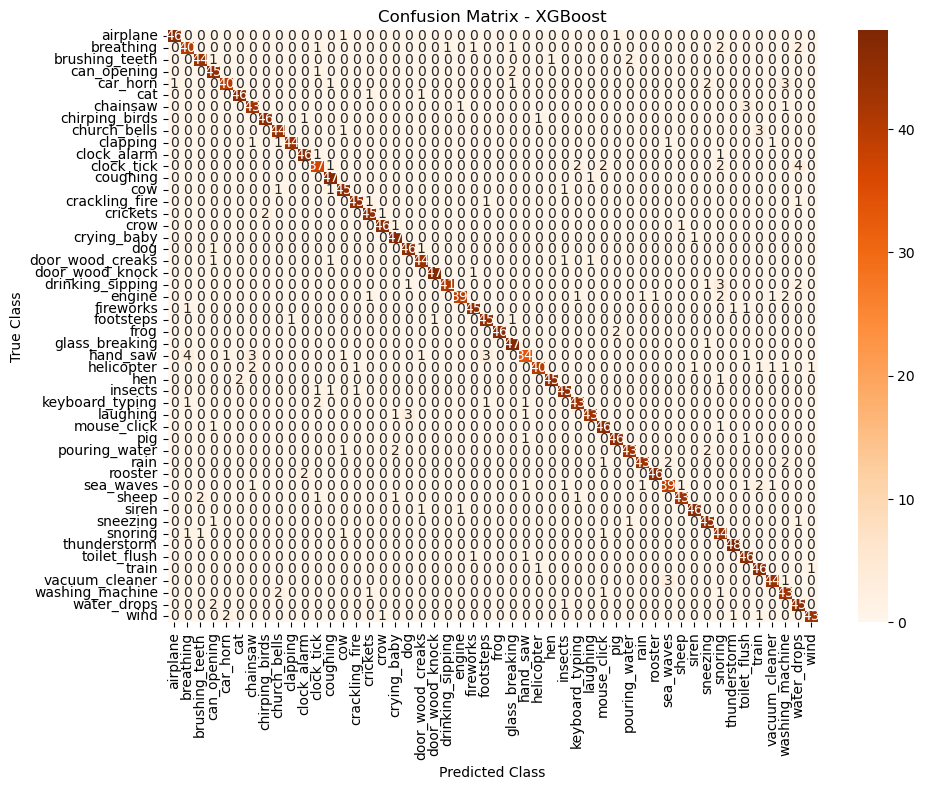

In [19]:
import os
import sys
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 1. Load or Generate Metadata CSV
# ---------------------------
csv_file = "augmented_esc50.csv"

def generate_dummy_csv(audio_dir="augmented_audio", csv_out="augmented_esc50.csv"):
    data = []
    for file in os.listdir(audio_dir):
        if file.endswith('.wav'):
            category = file.split('_')[0]
            data.append({'filename': file, 
                         'category': category, 
                         'filepath': os.path.join(audio_dir, file)})
    if data:
        df_dummy = pd.DataFrame(data)
        df_dummy.to_csv(csv_out, index=False)
        print("Dummy CSV generated with {} entries.".format(len(data)))
        return df_dummy
    else:
        sys.exit("No audio files found in the directory: '{}'".format(audio_dir))

if not os.path.exists(csv_file):
    print(f"CSV file '{csv_file}' not found. Generating dummy CSV...")
    df = generate_dummy_csv()
else:
    df = pd.read_csv(csv_file)
    if df.empty:
        print(f"CSV file '{csv_file}' is empty. Generating dummy CSV...")
        df = generate_dummy_csv()

if 'filepath' not in df.columns:
    print("No 'filepath' column found; generating file paths using 'filename' and 'augmented_audio' directory.")
    df['filepath'] = df['filename'].apply(lambda x: os.path.join('augmented_audio', x))

try:
    sample_path = df['filepath'].iloc[0]
except IndexError:
    sys.exit("Error: The CSV file does not contain any entries.")

if not os.path.exists(sample_path):
    print(f"Warning: Sample file '{sample_path}' does not exist. Please verify the location of your augmented audio files.")

# ---------------------------
# 2. Feature Extraction Function for XGBoost
# ---------------------------
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=44100)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        features = np.concatenate((mfcc_mean, mfcc_std))
        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# ---------------------------
# 3. Process Files: Extract Features & Labels
# ---------------------------
features = []
labels = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    file_path = row['filepath']
    category = row['category']
    feat = extract_features(file_path)
    if feat is not None:
        features.append(feat)
        labels.append(category)
    else:
        print(f"Skipping {file_path} due to extraction error.")

if len(features) == 0:
    sys.exit("Error: No features were extracted; please verify your file paths and audio files.")

features = np.array(features)
labels = np.array(labels)

# ---------------------------
# 4. Split Data into Training and Test Sets
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, stratify=labels, test_size=0.2, random_state=42
)

# ---------------------------
# 5. Encode Labels for XGBoost
# ---------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# ---------------------------
# 6. Train XGBoost Model
# ---------------------------
model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(le.classes_), random_state=42)
model.fit(X_train, y_train_enc)

# ---------------------------
# 7. Predict Classes for the Test Set
# ---------------------------
y_pred_enc = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

# ---------------------------
# 8. Evaluate the XGBoost Model
# ---------------------------
print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (weighted): {precision:.2f}")
print(f"Recall (weighted): {recall:.2f}")
print(f"F1 Score (weighted): {f1:.2f}")

# ---------------------------
# 9. Plot and Display the Confusion Matrix
# ---------------------------
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=sorted(list(set(y_train))))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=sorted(list(set(y_train))), yticklabels=sorted(list(set(y_train))))
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()